In [ ]:
import warnings, re, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

try:
    from sklearn.inspection import permutation_importance
    HAS_PERM = True
except Exception:
    HAS_PERM = False

print("HAS_LGBM =", HAS_LGBM, "| HAS_SHAP =", HAS_SHAP, "| HAS_PERM =", HAS_PERM)
print("cwd =", os.getcwd())


HAS_LGBM = True | HAS_SHAP = False | HAS_PERM = True
cwd = /home/sues03/shuomo/代码


In [ ]:

FEAT_PARQUET = Path("../data/2features/features.parquet")  # <-- 改成你的 features.parquet 路径
OUT_DIR = Path("../data/3models_可视化"); OUT_DIR.mkdir(parents=True, exist_ok=True)

DO_LOLO = True


In [ ]:

def add_rpm_normalized_features(df, feat_cols):
    freq_like = ["freq_peak", "spec_centroid", "freq_std", "spec_rolloff95", "rms_freq"]
    env_cols = ["bpfo_E", "bpfi_E", "bsf_E", "ftf_E"]
    df2 = df.copy()
    fr = (df2["rpm"].astype(float) / 60.0).replace([np.inf, -np.inf], np.nan)
    for c in freq_like:
        if c in df2.columns:
            df2[c+"_order"] = df2[c] / fr
    has_env = [c for c in env_cols if c in df2.columns]
    if has_env:
        total = df2[has_env].sum(axis=1) + 1e-12
        for c in has_env:
            df2[c+"_ratio"] = df2[c] / total
    new_cols = [c for c in df2.columns if c not in df.columns]
    return df2, feat_cols + new_cols

def group_from_segfile(p):
    name = Path(p).stem
    return re.sub(r"_seg\\d+$", "", name)

def barplot(values, labels, title, save_path):
    plt.figure(figsize=(8,5))
    idx = np.argsort(values)[::-1]
    vals_sorted = np.array(values)[idx]
    labels_sorted = np.array(labels)[idx]
    plt.bar(range(len(vals_sorted)), vals_sorted)
    plt.xticks(range(len(vals_sorted)), labels_sorted, rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

def scatter2d(x2d, y, title, save_path):
    plt.figure(figsize=(6,5))
    for cls in np.unique(y):
        m = (y == cls)
        plt.scatter(x2d[m,0], x2d[m,1], s=10, label=str(cls))
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

def plot_confusion(cm, labels, title, save_path):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect="auto")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f"{cm[i,j]:.0f}", ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()


In [ ]:

if not FEAT_PARQUET.exists():
    print("未找到", FEAT_PARQUET)
    print("当前目录内容：", os.listdir())
    raise FileNotFoundError("请修改 FEAT_PARQUET 为你的 features.parquet 实际路径")

df = pd.read_parquet(FEAT_PARQUET)
meta_cols = ["seg_file","label","load","rpm","size_code","clock_pos"]
for c in meta_cols:
    if c not in df.columns:
        raise ValueError(f"缺少列: {c}")

feat_cols = [c for c in df.columns if c not in meta_cols]
df, feat_cols = add_rpm_normalized_features(df, feat_cols)

labels = df["label"].astype(str).values
groups = df["seg_file"].apply(group_from_segfile).values
X = df[feat_cols].fillna(0).values
y = labels
label_order = sorted(np.unique(y).tolist())

print("样本数 =", len(y), "特征数 =", len(feat_cols), "类别 =", label_order)


样本数 = 16549 特征数 = 39 类别 = ['B', 'IR', 'N', 'OR']


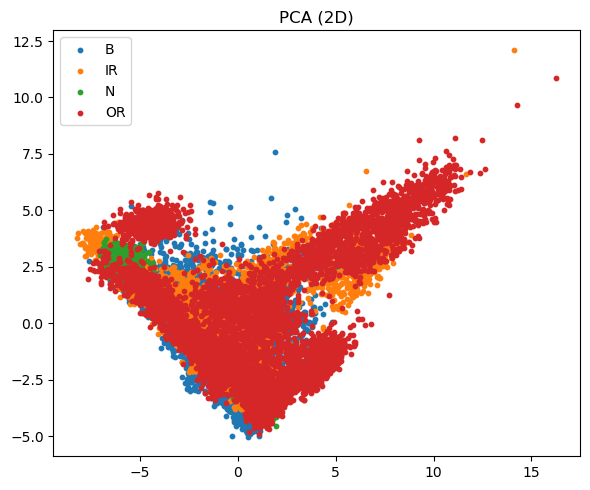

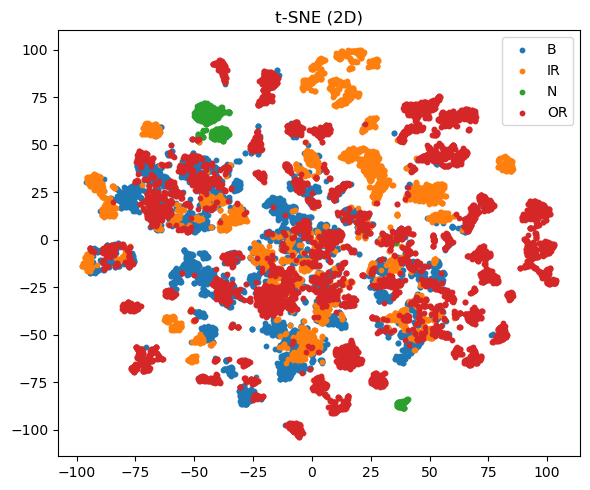

In [ ]:

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)
scatter2d(X_pca, y, "PCA (2D)", OUT_DIR/"pca_2d.png")

tsne = TSNE(n_components=2, random_state=42, init="pca", perplexity=30, learning_rate='auto')
X_tsne = tsne.fit_transform(X_std)
scatter2d(X_tsne, y, "t-SNE (2D)", OUT_DIR/"tsne_2d.png")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8565
[LightGBM] [Info] Number of data points in the train set: 13239, number of used features: 35
[LightGBM] [Info] Start training from score -1.386020
[LightGBM] [Info] Start training from score -1.386739
[LightGBM] [Info] Start training from score -1.386258
[LightGBM] [Info] Start training from score -1.386161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

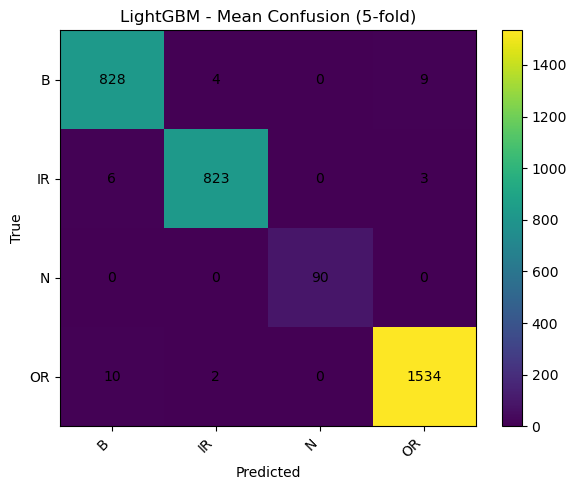

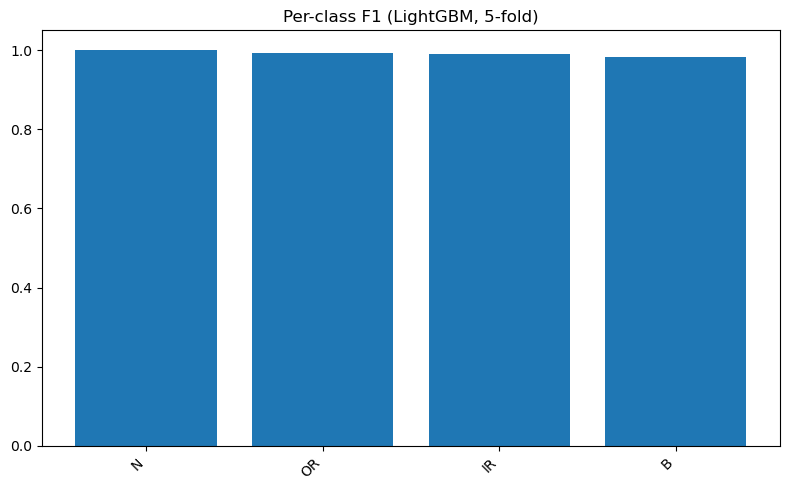

In [ ]:

if not HAS_LGBM:
    raise ImportError("未安装 LightGBM；请先安装或改用 RF。")

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

model = LGBMClassifier(
    objective="multiclass",
    num_class=len(label_order),
    n_estimators=700,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)

cnt = Counter(y)
avg_n = np.mean(list(cnt.values()))
class_weight = {c: avg_n/cnt[c] for c in cnt}
sample_weight_all = np.array([class_weight[t] for t in y], dtype=float)

cms = []
per_class_f1 = defaultdict(list)

for fold, (tr, te) in enumerate(cv.split(X, y, groups=groups), 1):
    X_tr, y_tr = X[tr], y[tr]
    X_te, y_te = X[te], y[te]
    sw_tr = sample_weight_all[tr]
    model.fit(X_tr, y_tr, sample_weight=sw_tr)
    y_pred = model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred, labels=label_order)
    cms.append(cm)
    report = classification_report(y_te, y_pred, labels=label_order, output_dict=True, zero_division=0)
    for cls in label_order:
        per_class_f1[cls].append(report[cls]["f1-score"])

cm_mean = np.mean(np.stack(cms, axis=0), axis=0)
plot_confusion(cm_mean, label_order, "LightGBM - Mean Confusion (5-fold)", OUT_DIR/"lgbm_cm_mean.png")

f1_mean = [np.mean(per_class_f1[cls]) for cls in label_order]
barplot(f1_mean, label_order, "Per-class F1 (LightGBM, 5-fold)", OUT_DIR/"lgbm_f1_per_class.png")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8566
[LightGBM] [Info] Number of data points in the train set: 16549, number of used features: 35
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

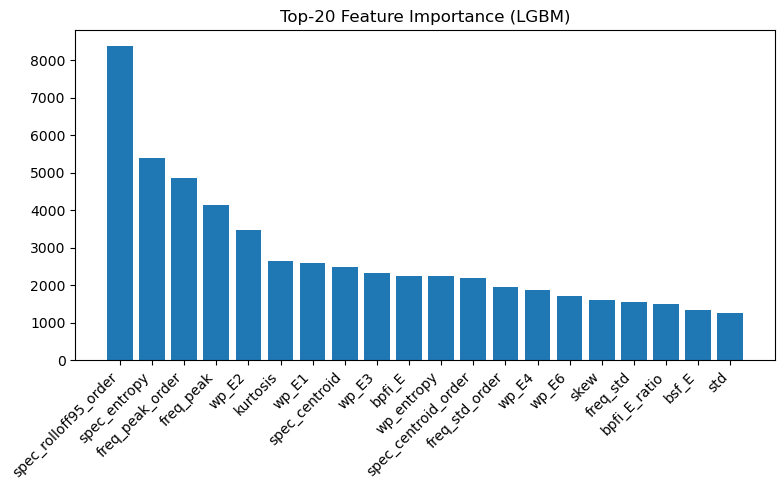

In [ ]:

model_full = LGBMClassifier(
    objective="multiclass",
    num_class=len(label_order),
    n_estimators=700,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)
model_full.fit(X, y, sample_weight=sample_weight_all)
importances = model_full.feature_importances_
topk = 20 if len(importances) >= 20 else len(importances)
top_idx = np.argsort(importances)[::-1][:topk]
barplot(importances[top_idx], [feat_cols[i] for i in top_idx], f"Top-{topk} Feature Importance (LGBM)", OUT_DIR/"lgbm_feat_importance_topk.png")


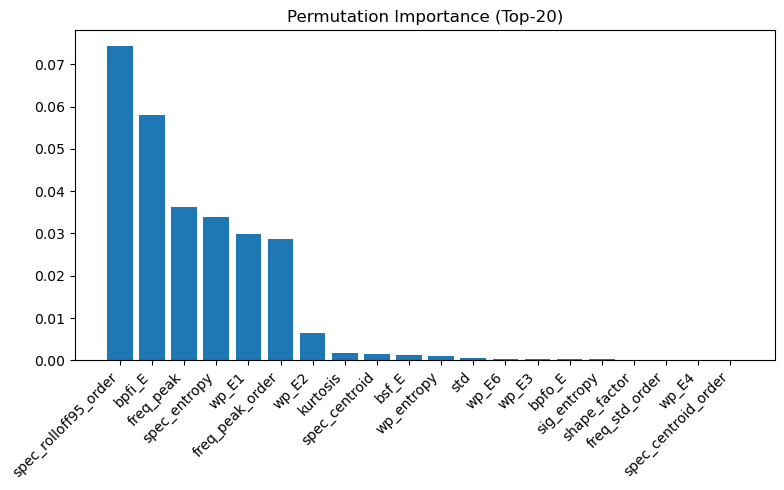

In [ ]:

if HAS_SHAP:
    explainer = shap.TreeExplainer(model_full)
    idx = np.random.RandomState(42).choice(len(X), size=min(2000, len(X)), replace=False)
    shap_values = explainer.shap_values(X[idx])
    shap.summary_plot(shap_values, pd.DataFrame(X[idx], columns=feat_cols), show=False)
    plt.title("SHAP Summary (sampled)")
    plt.tight_layout()
    plt.savefig(OUT_DIR/"lgbm_shap_summary.png", dpi=150)
    plt.show()
elif HAS_PERM:
    result = permutation_importance(model_full, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    imp_mean = result.importances_mean
    top_idx = np.argsort(imp_mean)[::-1][:20]
    barplot(imp_mean[top_idx], [feat_cols[i] for i in top_idx], "Permutation Importance (Top-20)", OUT_DIR/"lgbm_perm_importance_topk.png")
else:
    print("既没有 SHAP 也没有 permutation_importance，跳过此步。")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8552
[LightGBM] [Info] Number of data points in the train set: 12455, number of used features: 35
[LightGBM] [Info] Start training from score -1.413031
[LightGBM] [Info] Start training from score -1.402991
[LightGBM] [Info] Start training from score -1.315703
[LightGBM] [Info] Start training from score -1.416962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

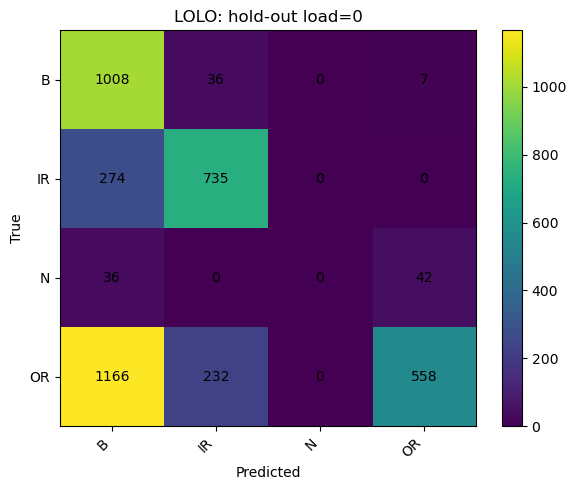

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8550
[LightGBM] [Info] Number of data points in the train set: 12376, number of used features: 35
[LightGBM] [Info] Start training from score -1.376292
[LightGBM] [Info] Start training from score -1.379662
[LightGBM] [Info] Start training from score -1.410961
[LightGBM] [Info] Start training from score -1.378666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

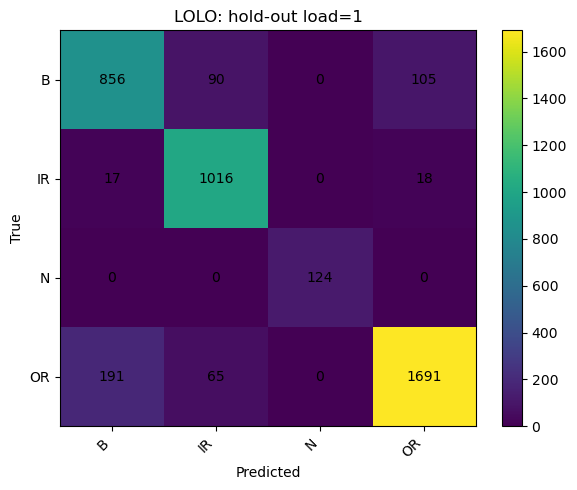

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8550
[LightGBM] [Info] Number of data points in the train set: 12408, number of used features: 35
[LightGBM] [Info] Start training from score -1.377685
[LightGBM] [Info] Start training from score -1.381054
[LightGBM] [Info] Start training from score -1.412353
[LightGBM] [Info] Start training from score -1.374543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

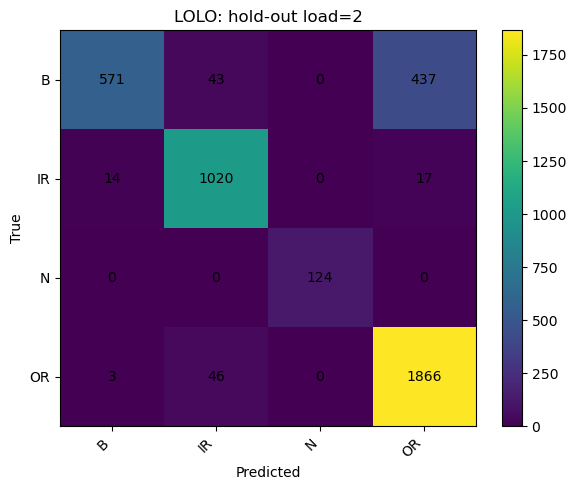

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8541
[LightGBM] [Info] Number of data points in the train set: 12408, number of used features: 35
[LightGBM] [Info] Start training from score -1.377685
[LightGBM] [Info] Start training from score -1.381054
[LightGBM] [Info] Start training from score -1.412353
[LightGBM] [Info] Start training from score -1.374543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

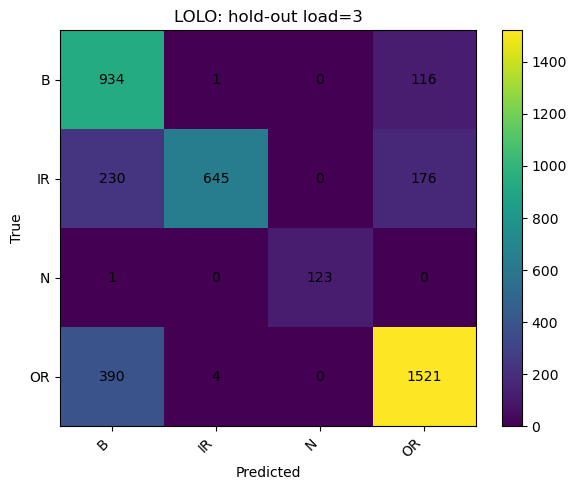

In [ ]:

if DO_LOLO:
    loads = np.array(df["load"].values)
    unique_loads = np.unique(loads)
    all_reports = {}
    for hold in unique_loads:
        m_te = (loads == hold)
        m_tr = ~m_te
        X_tr, y_tr = X[m_tr], y[m_tr]
        X_te, y_te = X[m_te], y[m_te]
        sw_tr = sample_weight_all[m_tr]
        clf = LGBMClassifier(
            objective="multiclass",
            num_class=len(label_order),
            n_estimators=700,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42
        )
        clf.fit(X_tr, y_tr, sample_weight=sw_tr)
        y_pred = clf.predict(X_te)
        cm = confusion_matrix(y_te, y_pred, labels=label_order)
        plot_confusion(cm, label_order, f"LOLO: hold-out load={hold}", OUT_DIR/f"lolo_load_{hold}_cm.png")
        rep = classification_report(y_te, y_pred, labels=label_order, output_dict=True, zero_division=0)
        all_reports[int(hold)] = rep
    # 保存报告
    pd.DataFrame({k: {f"{cls}_f1": v[cls]["f1-score"] for cls in label_order} for k, v in all_reports.items()}).T.to_csv(OUT_DIR/"lolo_per_class_f1.csv")
